# Acoplamento eletroacústico (alto-falante no baffle infinito)


O circuito eletromecânico do sistema é dado na figura.

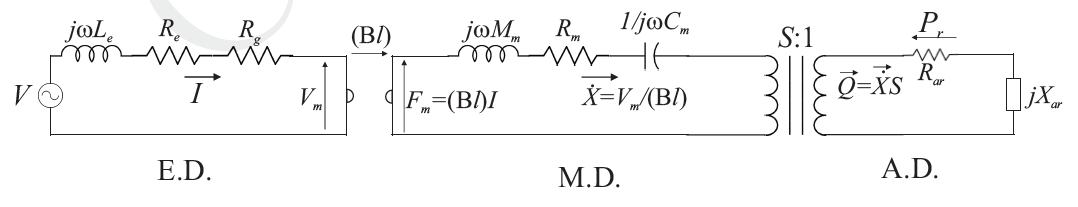

Se conseguirmos mensurar a velocidade de vibração do pistão, $\tilde{\dot{X}}$, podemos usar a Eq. (1) para mensurar a pressão sonora radiada na direção ***normal*** e a uma distância $r$ do pistão.

\begin{equation}
\tilde{P}(r,0^{\circ})=\text{j} 2 \rho_{0} c_{0} \tilde{\dot{X}} \ \sin\left[\frac{k_{0}}{2}\left(\sqrt{r^{2}+a^{2}}-r\right)\right] \ \text{e}^{-\text{j} (k_{0}/2) (\sqrt{r^{2}+a^{2}}+r)}
\tag{1}
\end{equation}

In [1]:
import numpy as np
from scipy import special
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

def zrad_piston_infbaffle(a, freq, rho0 = 1.21, c0 = 343):
    # Equivalent circuit
    Ra1 = (0.1404 * rho0 * c0) / (a**2)
    Ra2 = (rho0 * c0)/(np.pi * a**2)
    Ca1 = 5.94 *a**3/(rho0 * c0**2)
    Ma1 = (0.27 * rho0) / a
    # Equivalent impedance
    omega = 2*np.pi*freq
    Zrad_eq=(-(omega**2)*Ma1*Ra1*Ra2*Ca1+1j*omega*Ma1*(Ra1+Ra2))/\
        (Ra1+Ra2-(omega**2)*Ma1*Ra1*Ca1+1j*omega*(Ra1*Ra2*Ca1+Ma1))

    # Radiation impedance 
    k0 = omega/c0; 
    #s = pi*a^2;
    Jka = special.jv(1,2*k0*a)
    Ska = special.struve(1,2*k0*a)

    R1 = 1 - 2*Jka/(2*k0*a);
    X1 = 2*Ska/(2*k0*a);

    Zrad = (rho0*c0/(np.pi*a**2))*(R1 + 1j*X1)
    return Ra1, Ra2, Ca1, Ma1, Zrad_eq, Zrad

def pres_spkbaffle_odeg(freq, X, r, a, rho0 = 1.21, c0 = 343):
    w = 2 * np.pi * freq
    k0 = w/c0
    pres = 1j*2*rho0*c0 * X *\
        (np.sin((k0/2)*(np.sqrt(r**2+a**2)-r))) *\
        np.exp(-1j*(k0/2)*(np.sqrt(r**2+a**2)+r))
    return pres

# Imports

Vamos importar dados de medição e de simulação do SPICE. Os dados são
- Impedância elétrica medida e simulada
- Velocidade de vibração do cone (simulada)
- Curva de resposta medida a 1 [m] do falante no baffle infinito

***OBS: dados experimentais fornecidos pelo Eng. John William Skalee.***

In [2]:
# Impedância medida
filename = '6w16p_Ze.txt'
data = np.loadtxt(filename, skiprows=0)
freq_m_Ze = data[:,0]
Ze_m = data[:,1]

# Impedância simulada
filename = 'Ze_Spice.txt'
data = np.loadtxt(filename, skiprows=1)
freq_s_Ze = data[:,0]
Ze_s = data[:,1] + 1j*data[:,2]

# Velocidade de vibração do cone (simulada)
filename = 'conevel_spice.txt'
data = np.loadtxt(filename, skiprows=1)
freq_s_vcone = data[:,0]
X_s = data[:,1] + 1j*data[:,2]

# Curva de resposta do alto-falante (1W/1m)
filename = '6w16p_p1W1m.txt'
data = np.loadtxt(filename, skiprows=0)
freq_m_p = data[:,0]
SPL_m = data[:,1]

# Dados de catálogo do alto-falante

In [3]:
# lado elétrico
Vin = 5.66 # Amplitude da tensão de alimentação - (V_rms**2)/16 = 1 [W]
Re = 12.29 # Ohm 
Le = 0.502e-3 # H

# lado mecânico
Mm = 15.7e-3 # kg 
Cm = 0.113e-3 # m/N
Rm = 0.911 # Ns/m
Bl = 10.66 # Vs/m

# lado acústico
Sd = 143.4e-4 # m^2
ad = np.sqrt(Sd/np.pi) # considera a geometria cônica e parte da suspensão
Ra1, Ra2, Ca, Ma, Zrad_eq, Zrad = zrad_piston_infbaffle(ad, freq_s_vcone, rho0 = 1.21, c0 = 343)

print("1/Ra1: {}".format(1/Ra1))
print("1/Ra2: {}".format(1/Ra2))
print("Ca: {}".format(Ca))
print("Ma: {}".format(Ma))

1/Ra1: 7.83344287107718e-05
1/Ra2: 3.455171915283233e-05
Ca: 1.2868020749841235e-08
Ma: 4.835590271310726


In [4]:
# Impedância elétrica (analítica)
w = 2 * np.pi * freq_s_vcone
Zem = (Bl**2)/(1j*w*Mm + Rm + (1/(1j*w*Cm))+(Sd**2)*Zrad)
Ze_a = 1j*w*Le + Re + Zem

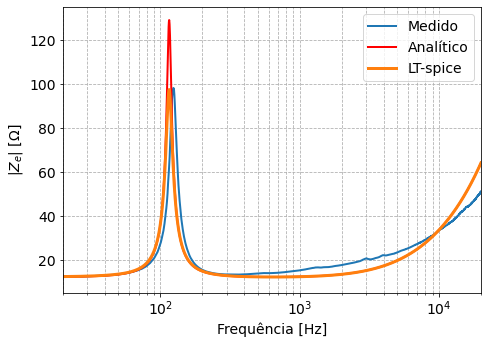

In [5]:
# Comparativo das impedâncias
fig = plt.figure(figsize = (7,5))
plt.semilogx(freq_m_Ze, Ze_m, '-', linewidth = 2, label = "Medido")
plt.semilogx(freq_s_Ze, np.abs(Ze_a), 'r',  linewidth = 2, label = "Analítico")
plt.semilogx(freq_s_Ze, np.abs(Ze_s), linewidth = 3, label = "LT-spice")
plt.legend()
plt.grid(linestyle = '--', which='both')
plt.xlim((20, 20000))
plt.xlabel('Frequência [Hz]')
plt.ylabel(r'$|Z_e|$ [$\Omega$]')
plt.tight_layout()

### Pressão sonora a 1 [m]

In [6]:
# Comparativo entre as curvas de resposta
r = 1
# Pressão sonora calculada a partir da vibração do cone Spice
P_s = pres_spkbaffle_odeg(freq_s_vcone, X_s, r, ad, rho0 = 1.21, c0 = 343)

In [7]:
# Pressão sonora calculada a partir da vibração do cone (modelo analítico)
X_a = (Bl/Ze_a)*(((Bl**2)/Ze_a) + 1j*w*Mm + Rm + (1/(1j*w*Cm)) + (Sd**2)*(Zrad))**(-1)
P_a = pres_spkbaffle_odeg(freq_s_vcone, X_a, r, ad, rho0 = 1.21, c0 = 343)

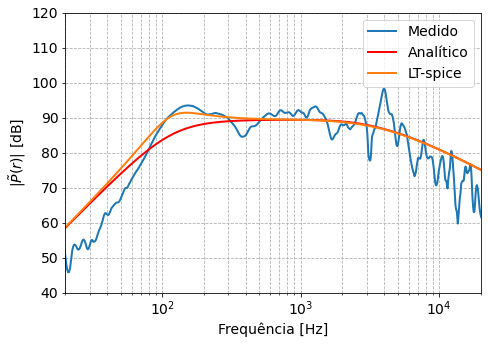

In [8]:
fig = plt.figure(figsize = (7,5))
plt.semilogx(freq_m_p, SPL_m, '-', linewidth = 2, label = "Medido")
plt.semilogx(freq_s_vcone, 20*np.log10(np.abs(Vin*P_a/np.sqrt(2))/20e-6), 'r', linewidth = 2, label = "Analítico")
plt.semilogx(freq_s_vcone, 20*np.log10(np.abs(P_s/np.sqrt(2))/20e-6), linewidth = 2, label = "LT-spice")
plt.legend()
plt.grid(linestyle = '--', which='both')
plt.xlim((20, 20000))
plt.ylim((40, 120))
plt.xlabel('Frequência [Hz]')
plt.ylabel(r'$|\tilde{P}(r)|$ [dB]')
plt.tight_layout()